In [25]:
# _*_ coding: utf-8 _*_
# @Time: 2022/02/21 16:05 
# @Author: yuyongsheng
# @Software: PyCharm
# @Description: 东方肝胆-肝门胆管癌：1. 逐步向前 2. 建模

In [26]:
# 导入程序包
import pymysql as MySQLDB
import pandas as pd
import numpy as np

import re
import sys
import os
project_path = os.getcwd()

In [27]:
# 字符串转换为时间格式
import datetime
def str_to_datetime(x):
    try:
        a = datetime.datetime.strptime(x, "%d/%m/%Y %H:%M:%S")
        return a
    except:
        return np.NaN

# 数据清洗

In [28]:
df_model=pd.read_excel(project_path+'/data/processed_data/df_3.2.2_术前预后model数据集.xlsx')
if 'Unnamed: 0' in df_model.columns:
    df_model = df_model.drop(['Unnamed: 0'], axis=1)

In [29]:
print(df_model.shape)

(419, 57)


## 删除无关特征

In [30]:
df_model.columns

Index(['id', 'sampling', 'gender', 'age', 'height', 'weight', 'BMI',
       'jaundice', 'emaciation', 'breath_disease', 'cardio_disease', 'nbdd',
       'urinary_disease', 'endocrine_disease', 'biliary_disease',
       'other_disease', 'smoke', 'drinking', 'family_history', 'blood_type',
       'WBC', 'HGB', 'PLT', 'TB', 'DB', 'TP', 'ALB', 'LG', 'AG', 'PAB', 'ALT',
       'AST', 'GT', 'ALP', 'tumor_AFP', 'tumor_CEA', 'tumor_CA19-9',
       'tumor_CA125', 'tumor_size', 'HBsAg', 'HBeAg', 'HBeAb', 'HBcAb',
       'HCVAb', 'LC', 'Gazzaniga_T', 'MSKCC', 'Blumgart_T', 'Bismuth_C',
       'PTCD_ERCP', '手术日期', 'gene_mutation', 'gene_MSI', 'TMB', 'target_death',
       'target_survival_month', 'label'],
      dtype='object')

In [31]:
df_model=df_model.drop(['id','sampling','手术日期','target_death','target_survival_month'],axis=1)

In [32]:
df_model.shape

(419, 52)

## 删除高线性相关的变量

In [33]:
df_model.columns

Index(['gender', 'age', 'height', 'weight', 'BMI', 'jaundice', 'emaciation',
       'breath_disease', 'cardio_disease', 'nbdd', 'urinary_disease',
       'endocrine_disease', 'biliary_disease', 'other_disease', 'smoke',
       'drinking', 'family_history', 'blood_type', 'WBC', 'HGB', 'PLT', 'TB',
       'DB', 'TP', 'ALB', 'LG', 'AG', 'PAB', 'ALT', 'AST', 'GT', 'ALP',
       'tumor_AFP', 'tumor_CEA', 'tumor_CA19-9', 'tumor_CA125', 'tumor_size',
       'HBsAg', 'HBeAg', 'HBeAb', 'HBcAb', 'HCVAb', 'LC', 'Gazzaniga_T',
       'MSKCC', 'Blumgart_T', 'Bismuth_C', 'PTCD_ERCP', 'gene_mutation',
       'gene_MSI', 'TMB', 'label'],
      dtype='object')

In [34]:
corr_result=df_model[['gender', 'age', 'height', 'weight', 'BMI', 'jaundice', 'emaciation',
       'breath_disease', 'cardio_disease', 'nbdd', 'urinary_disease',
       'endocrine_disease', 'biliary_disease', 'other_disease', 'smoke',
       'drinking', 'family_history', 'blood_type', 'WBC', 'HGB', 'PLT', 'TB',
       'DB', 'TP', 'ALB', 'LG', 'AG', 'PAB', 'ALT', 'AST', 'GT', 'ALP',
       'tumor_AFP', 'tumor_CEA', 'tumor_CA19-9', 'tumor_CA125', 'tumor_size',
       'HBsAg', 'HBeAg', 'HBeAb', 'HBcAb', 'HCVAb', 'LC', 'Gazzaniga_T',
       'MSKCC', 'Blumgart_T', 'Bismuth_C', 'PTCD_ERCP', 'gene_mutation',
       'gene_MSI', 'TMB', 'label']].corr()

In [35]:
corr_result[corr_result>0.5].to_excel(project_path+'/data/result/feature_engineering/corr.xlsx')

In [36]:
'''
总胆红素、直接胆红素：0.98
球蛋白、乙肝e抗原：0.97
MSKCC、Blumgart：0.99
'''
df_model=df_model.drop(['TB','LG'],axis=1)

In [37]:
df_model.to_excel(project_path+'/data/result/feature_engineering/df_1.2_删除高线性相关变量.xlsx')

## 删除缺失超过50%的特征

### 删除列缺失超过50%的列

In [38]:
protect_col=['blood_type','gene_MSI']
col=[i for i in df_model.columns if i not in protect_col]
for i in col:
    if df_model[i].isnull().sum()/df_model.shape[0] >= 0.5:
        print(i)
        del df_model[i]

TMB


In [39]:
print(df_model.shape) 

(419, 49)


### 删除行缺失超过50%的行

In [40]:
df_model=df_model.reset_index(drop=True)
for i in range(df_model.shape[0]):
    if df_model.loc[i].isnull().sum()/df_model.loc[i].shape[0] >= 0.5:
        print(i)
        df_model.drop([i],axis=0,inplace=True)

176
251
407


In [41]:
# 删除缺失超过50%的特征
writer=pd.ExcelWriter(project_path+'/data/result/feature_engineering/df_1.3_删除缺失超过50%.xlsx')
df_model.to_excel(writer)
writer.save()

## 删除分类极不平衡的特征

In [42]:
# 保护目标变量、tdm数据
protect_col=['blood_type','gene_MSI']
col=[i for i in df_model.columns if i not in protect_col]
for i in col:
    if df_model[i].nunique() < 2:
        print(i)
        del df_model[i]
        continue
    if df_model[i].nunique() == 2:
        # 如果分类变量中某一变量的占比超过90%，则删除该指标
        num_1 = df_model[i].value_counts()  # df一列中不同变量的数目
        num_2 = num_1.div(df_model.shape[0])  # div除法，所有元素都除以相同数值
        num_3 = num_2.max()  # 取出最大值
        if num_3 >= 0.9:
            print(i)
            del df_model[i]

breath_disease
urinary_disease
family_history


In [43]:
df_model.shape

(416, 46)

In [44]:
# 删除缺失超过50%的特征
df_model.to_excel(project_path+'/data/result/feature_engineering/df_1.4_删除分类极不平衡.xlsx')

## 过滤异常值

In [45]:
# 过滤异常值，大于正常值超过100倍！
protect_col=['label']
col=[i for i in df_model.columns if i not in protect_col]
for i in col:
    # 测试特征是否存在异常值
    median_value= max(df_model[i].median(),1)
    max_value = df_model[i].astype(float).max()
    if max_value > 100 * median_value:
        print(i)
    df_model[i]=df_model[i].apply(lambda x: np.nan if pd.isnull(x) else 
                                            np.nan if float(x) > 100*median_value else x)

tumor_AFP


In [46]:
df_model.shape

(416, 46)

In [47]:
# 保存特征清洗
df_model.to_excel(project_path + '/data/result/feature_engineering/df_1_特征清洗.xlsx')

# 显著性检验

In [48]:
df_model.columns

Index(['gender', 'age', 'height', 'weight', 'BMI', 'jaundice', 'emaciation',
       'cardio_disease', 'nbdd', 'endocrine_disease', 'biliary_disease',
       'other_disease', 'smoke', 'drinking', 'blood_type', 'WBC', 'HGB', 'PLT',
       'DB', 'TP', 'ALB', 'AG', 'PAB', 'ALT', 'AST', 'GT', 'ALP', 'tumor_AFP',
       'tumor_CEA', 'tumor_CA19-9', 'tumor_CA125', 'tumor_size', 'HBsAg',
       'HBeAg', 'HBeAb', 'HBcAb', 'HCVAb', 'LC', 'Gazzaniga_T', 'MSKCC',
       'Blumgart_T', 'Bismuth_C', 'PTCD_ERCP', 'gene_mutation', 'gene_MSI',
       'label'],
      dtype='object')

In [49]:
discrete_col=['gender','jaundice','emaciation','cardio_disease','nbdd','endocrine_disease','biliary_disease','other_disease',
             'smoke','drinking','blood_type','HBsAg','HBeAg','HBeAb','HBcAb','HCVAb','LC','Gazzaniga_T','MSKCC','Bismuth_C',
             'PTCD_ERCP','gene_mutation','gene_MSI']
continuous_col=[x for x in df_model.columns if x not in discrete_col]
continuous_col.remove('label')

## 分类变量显著性检验

In [50]:
# 分类-分类：卡方

In [51]:
from scipy.stats import chi2_contingency
feature_list=[]
y_list=[]
t_list=[]
p_list=[]
sig_list=[]
for i in discrete_col:
    print(i)
    result = chi2_contingency(pd.crosstab(df_model['label'],df_model[i]))
    t,p=result[0:2]
    t=round(t,2)
    p=round(p,3)
    feature_list.append(i)
    y_list.append('卡方检验')
    t_list.append(t)
    p_list.append(p)
    if p <=0.05:
        sig='显著'
    else:
        sig='不显著'
    sig_list.append(sig)

gender
jaundice
emaciation
cardio_disease
nbdd
endocrine_disease
biliary_disease
other_disease
smoke
drinking
blood_type
HBsAg
HBeAg
HBeAb
HBcAb
HCVAb
LC
Gazzaniga_T
MSKCC
Bismuth_C
PTCD_ERCP
gene_mutation
gene_MSI


In [52]:
df_discrete_corr_sig=pd.DataFrame(data={'feature':discrete_col,
                                        'method':y_list,
                                        't':t_list,
                                        'p':p_list,
                                        'result':sig_list})

In [53]:
# 连续-分类变量相关性分析
df_discrete_corr_sig.to_excel(project_path+'/data/result/feature_engineering/df_2.1_分类-分类变量显著性检验.xlsx')

In [54]:
df_discrete_corr_sig

,feature,method,t,p,result
0,gender,卡方检验,3.33,0.343,不显著
1,jaundice,卡方检验,16.32,0.001,显著
2,emaciation,卡方检验,2.63,0.853,不显著
3,cardio_disease,卡方检验,1.33,0.722,不显著
4,nbdd,卡方检验,6.36,0.095,不显著
5,endocrine_disease,卡方检验,3.99,0.263,不显著
6,biliary_disease,卡方检验,9.09,0.028,显著
7,other_disease,卡方检验,3.99,0.262,不显著
8,smoke,卡方检验,3.86,0.277,不显著
9,drinking,卡方检验,6.56,0.087,不显著


In [55]:
discrete_relate=list(df_discrete_corr_sig[df_discrete_corr_sig.result=='显著']['feature'])

In [56]:
discrete_relate

['jaundice',
 'biliary_disease',
 'HBsAg',
 'HBeAg',
 'Gazzaniga_T',
 'MSKCC',
 'Bismuth_C',
 'gene_mutation']

In [57]:
list(df_discrete_corr_sig[df_discrete_corr_sig.result=='不显著']['feature'])

['gender',
 'emaciation',
 'cardio_disease',
 'nbdd',
 'endocrine_disease',
 'other_disease',
 'smoke',
 'drinking',
 'blood_type',
 'HBeAb',
 'HBcAb',
 'HCVAb',
 'LC',
 'PTCD_ERCP',
 'gene_MSI']

In [58]:
# 保留业务需要的不显著变量
discrete_relate.extend(['gender', 'emaciation', 'cardio_disease', 'nbdd','endocrine_disease', 'smoke', 'drinking',
                         'blood_type', 'HBcAb','HCVAb','LC','PTCD_ERCP', 'gene_MSI'])

In [59]:
discrete_relate

['jaundice',
 'biliary_disease',
 'HBsAg',
 'HBeAg',
 'Gazzaniga_T',
 'MSKCC',
 'Bismuth_C',
 'gene_mutation',
 'gender',
 'emaciation',
 'cardio_disease',
 'endocrine_disease',
 'smoke',
 'drinking',
 'blood_type',
 'HBcAb',
 'HCVAb',
 'LC',
 'PTCD_ERCP',
 'gene_MSI']

## 连续变量显著性检验

In [60]:
# 多分类-连续：方差分析

In [61]:
import scipy.stats as st
# 连续变量的显著性检验
def test2(data_a,data_b,data_c,data_d):
    x = 1
    y = '单因素方差分析'
    t, p = st.f_oneway(list(data_a),list(data_b),list(data_c),list(data_d))
    return x,y,t,p

In [62]:
def sig_test(df_model,continuous_col):

    feature_list=[]  # 特征列表
    y_list=[]  # 显著性检验方法
    t_list=[]  # 统计量
    p_list=[]  # p值
    result_list=[]  # 是否显著

    for i in continuous_col:
        print(i)
        # 含有空值，方差分析返回nan
        df_model_nt=df_model[df_model[i].notnull()]
        # 多分类：4类
        data_1=df_model_nt[df_model_nt['label']==0][i]
        data_2=df_model_nt[df_model_nt['label']==1][i]
        data_3=df_model_nt[df_model_nt['label']==2][i]
        data_4=df_model_nt[df_model_nt['label']==3][i]
        print(data_1,data_2,data_3,data_4)
        # 计算高低剂量组显著性差异
        if df_model.shape[0] >= 10:
            # 连续变量检验
            x,y,t,p = test2(data_1,data_2,data_3,data_4)
            t=round(t,2)
            p=round(p,3)
            if p <=0.05:
                sig='显著'
            else:
                sig='不显著'
            # 显著性 
            feature_list.append(i)
            y_list.append(y)
            t_list.append(t)
            p_list.append(p)
            result_list.append(sig)
    df_result=pd.DataFrame({'特征':feature_list,
                            '检验指标':y_list,
                            't值':t_list,
                            'p值':p_list,
                            '显著性结果':result_list})
    return df_result

In [63]:
continuous_col

['age',
 'height',
 'weight',
 'BMI',
 'WBC',
 'HGB',
 'PLT',
 'DB',
 'TP',
 'ALB',
 'AG',
 'PAB',
 'ALT',
 'AST',
 'GT',
 'ALP',
 'tumor_AFP',
 'tumor_CEA',
 'tumor_CA19-9',
 'tumor_CA125',
 'tumor_size',
 'Blumgart_T']

In [64]:
df_model.head()

,gender,age,height,weight,BMI,jaundice,emaciation,cardio_disease,nbdd,endocrine_disease,...,HCVAb,LC,Gazzaniga_T,MSKCC,Blumgart_T,Bismuth_C,PTCD_ERCP,gene_mutation,gene_MSI,label
0,0.0,57.0,155.0,45.0,18.73,0,0.0,0.0,0.0,0.0,...,NaN,0.0,1.0,1.0,1.0,3.0,0.0,0,NaN,3
1,1.0,67.0,167.0,64.0,22.95,1,2.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0,NaN,1
2,1.0,50.0,165.0,65.5,24.06,1,2.0,0.0,0.0,0.0,...,0.0,NaN,1.0,1.0,1.0,3.0,1.0,0,NaN,1
3,1.0,60.0,170.0,86.0,29.76,1,2.0,1.0,0.0,1.0,...,0.0,NaN,2.0,2.0,3.0,4.0,1.0,0,NaN,1
4,1.0,58.0,172.0,70.0,23.66,1,0.0,1.0,0.0,0.0,...,0.0,NaN,4.0,3.0,4.0,4.0,1.0,0,NaN,1


In [65]:
df_continuous_sig = sig_test(df_model,continuous_col)
df_continuous_sig = df_continuous_sig.reset_index(drop=True)

age
38     59.0
42     56.0
43     64.0
44     45.0
45     70.0
       ... 
414    66.0
415    52.0
416    67.0
417    40.0
418    62.0
Name: age, Length: 99, dtype: float64 1      67.0
2      50.0
3      60.0
4      58.0
5      66.0
       ... 
340    59.0
345    58.0
364    50.0
367    60.0
403    57.0
Name: age, Length: 110, dtype: float64 7      49.0
25     51.0
30     53.0
31     71.0
32     60.0
       ... 
360    66.0
363    51.0
368    65.0
370    60.0
371    60.0
Name: age, Length: 129, dtype: float64 0      57.0
21     48.0
29     43.0
33     46.0
34     62.0
       ... 
369    58.0
372    61.0
373    41.0
375    60.0
377    57.0
Name: age, Length: 77, dtype: float64
height
136    158.0
161    174.0
196    173.0
197    170.0
200    170.0
202    158.0
204    172.0
228    166.0
275    175.0
279    165.0
287    170.0
308    155.0
320    178.0
334    165.0
335    175.0
339    172.0
347    170.0
349    174.0
361    163.0
374    162.0
376    170.0
378    165.0
379    180.0
Name: he

In [66]:
df_continuous_sig

,特征,检验指标,t值,p值,显著性结果
0,age,单因素方差分析,1.41,0.241,不显著
1,height,单因素方差分析,2.31,0.076,不显著
2,weight,单因素方差分析,2.02,0.112,不显著
3,BMI,单因素方差分析,1.04,0.374,不显著
4,WBC,单因素方差分析,0.49,0.689,不显著
5,HGB,单因素方差分析,1.12,0.339,不显著
6,PLT,单因素方差分析,4.42,0.005,显著
7,DB,单因素方差分析,4.34,0.005,显著
8,TP,单因素方差分析,1.08,0.358,不显著
9,ALB,单因素方差分析,1.42,0.236,不显著


In [67]:
# 多分类-连续方差分析
df_continuous_sig.to_excel(project_path+r'/data/result/feature_engineering/df_2.2_多分类-连续变量显著性检验.xlsx')

In [68]:
continuous_relate = list(df_continuous_sig[df_continuous_sig['显著性结果']=='显著']['特征'])

In [69]:
continuous_relate

['PLT',
 'DB',
 'PAB',
 'tumor_CEA',
 'tumor_CA19-9',
 'tumor_CA125',
 'tumor_size',
 'Blumgart_T']

In [70]:
list(df_continuous_sig[df_continuous_sig['显著性结果']=='不显著']['特征'])

['age',
 'height',
 'weight',
 'BMI',
 'WBC',
 'HGB',
 'TP',
 'ALB',
 'AG',
 'ALT',
 'AST',
 'GT',
 'ALP',
 'tumor_AFP']

In [71]:
# 业务角度需要保留：
continuous_relate.extend(['age','BMI','WBC','HGB','TP','ALB','AG','ALT','AST','ALP','tumor_AFP'])

In [72]:
# 提取相关性特征
feature_relate=discrete_relate + continuous_relate
# 加入目标变量
feature_relate.insert(0,'label')
df_model_relate=df_model[feature_relate]

In [75]:
feature_relate

['label',
 'jaundice',
 'biliary_disease',
 'HBsAg',
 'HBeAg',
 'Gazzaniga_T',
 'MSKCC',
 'Bismuth_C',
 'gene_mutation',
 'gender',
 'emaciation',
 'cardio_disease',
 'endocrine_disease',
 'smoke',
 'drinking',
 'blood_type',
 'HBcAb',
 'HCVAb',
 'LC',
 'PTCD_ERCP',
 'gene_MSI',
 'PLT',
 'DB',
 'PAB',
 'tumor_CEA',
 'tumor_CA19-9',
 'tumor_CA125',
 'tumor_size',
 'Blumgart_T',
 'age',
 'BMI',
 'WBC',
 'HGB',
 'TP',
 'ALB',
 'AG',
 'ALT',
 'AST',
 'ALP',
 'tumor_AFP']

In [73]:
df_model_relate.shape

(416, 40)

In [74]:
# 保存显著性分析结果
writer = pd.ExcelWriter(project_path + '/data/result/feature_engineering/df_2_data_model_relate.xlsx')
df_model_relate.to_excel(writer)
writer.save()

# 重要性评分

In [56]:
df_model_relate.shape

(417, 35)

In [57]:
from sklearn.model_selection import train_test_split

# 划分训练集和测试集，比例为8:2
x = df_model_relate.drop(['label'],axis=1)
y = df_model_relate['label']
tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=5)

In [58]:
# 重要性
import catboost,xgboost
model_boost=xgboost.XGBClassifier(max_depth=5,
                                learning_rate=0.01,
                                n_estimators=500,
                                min_child_weight=0.5,
                                eta=0.1,
                                gamma=0.5,
                                reg_lambda=10,
                                subsample=0.5,
                                colsample_bytree=0.8,
                                nthread=4,
                                scale_pos_weight=1)
model_boost.fit(tran_x,tran_y)
importance = model_boost.feature_importances_
print(tran_x.columns)
print(importance)

Index(['jaundice', 'biliary_disease', 'HBsAg', 'HBeAg', 'Gazzaniga_T', 'MSKCC',
       'Bismuth_C', 'gene_mutation', 'gender', 'emaciation',
       'endocrine_disease', 'smoke', 'drinking', 'HBcAb', 'HCVAb', 'LC',
       'PTCD_ERCP', 'PLT', 'TB', 'DB', 'PAB', 'tumor_CEA', 'tumor_CA19-9',
       'tumor_CA125', 'tumor_size', 'Blumgart_T', 'age', 'BMI', 'WBC', 'HGB',
       'ALB', 'GT', 'ALP', 'tumor_AFP'],
      dtype='object')
[0.01901558 0.02176166 0.02187417 0.02187528 0.04316934 0.05585419
 0.02332306 0.03788508 0.02548672 0.02211595 0.0193367  0.02842419
 0.0235086  0.02191101 0.02049894 0.0274448  0.02105105 0.03154247
 0.02421382 0.04165501 0.02671124 0.02335128 0.04507888 0.02784907
 0.03370343 0.05865825 0.02252797 0.05572123 0.0262429  0.02615051
 0.02419209 0.0280241  0.02700222 0.0228392 ]


In [59]:
df_importance= pd.DataFrame(data={'特征':tran_x.columns,'重要性评分':importance})
df_importance['重要性评分']=df_importance['重要性评分'].apply(lambda x: round(x,3))
df_importance=df_importance.sort_values(['重要性评分'],ascending=False)
df_importance=df_importance.reset_index(drop=True)

In [60]:
df_importance.to_excel(project_path + '/data/result/feature_engineering/df_3_模型重要性评分.xlsx')

In [61]:
# 筛选重要特征组建建模数据
df_importance_select=df_importance[df_importance['重要性评分']>0]
select_list = list(df_importance_select['特征'])
select_list.insert(0,'label')

In [62]:
df_model_importance = df_model_relate[select_list]

In [63]:
df_model_importance.shape

(417, 35)

In [64]:
# 保存重要性评分筛选后的建模数据
df_model_importance.to_excel(project_path + '/data/result/feature_engineering/df_3_data_model_importance.xlsx')

# 逐步向前

## 插补数据

In [65]:
# 使用随机森林对缺失值进行插补
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def missing_value_interpolation(df):
    df = df.reset_index(drop=True)
    # 提取存在缺失值的列名
    missing_list = []
    for i in df.columns:
        if df[i].isnull().sum() > 0:
            missing_list.append(i)
    missing_list_copy = missing_list.copy()
    # 用该列未缺失的值训练随机森林，然后用训练好的rf预测缺失值
    for i in range(len(missing_list)):
        name=missing_list[0]
        df_missing = df[missing_list_copy]
        # 将其他列的缺失值用0表示。
        missing_list.remove(name)
        for j in missing_list:
            df_missing[j]=df_missing[j].astype('str').apply(lambda x: 0 if x=='nan' else x)
        df_missing_is = df_missing[df_missing[name].isnull()]
        df_missing_not = df_missing[df_missing[name].notnull()]
        y = df_missing_not[name]
        x = df_missing_not.drop([name],axis=1)
        # 列出参数列表
        tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
        # 进行参数的搜索组合
        grid = GridSearchCV(RandomForestRegressor(),param_grid=tree_grid_parameter,cv=3)
        #rfr=RandomForestRegressor(random_state=0,n_estimators=100,n_jobs=-1)
        #根据已有数据去拟合随机森林模型
        grid.fit(x, y)
        rfr = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'])
        rfr.fit(x, y)
        #预测缺失值
        predict = rfr.predict(df_missing_is.drop([name],axis=1))
        #填补缺失值
        df.loc[df[name].isnull(),name] = predict
    return df

In [66]:
# df_model_cb=missing_value_interpolation(df_model_relate)
df_model_cb=df_model_relate

In [67]:
df_model_cb.shape

(417, 35)

In [68]:
df_model_cb.to_excel(project_path+'/data/result/feature_engineering/df_4.1_df_model_cb_before.xlsx')

## 划分数据集和过采样

In [69]:
from sklearn.model_selection import train_test_split
# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['label'],axis=1)
y = df_model_cb['label']

tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

In [70]:
tran_x.shape

(333, 34)

In [71]:
tran_y.value_counts()

2    103
0     83
1     81
3     66
Name: label, dtype: int64

In [72]:
test_y.value_counts()

1    30
2    26
0    17
3    11
Name: label, dtype: int64

## stepwise forward for regression

In [73]:
?SFS

Object `SFS` not found.


In [77]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
import xgboost,catboost
import sklearn
import numpy,pandas,scipy

In [79]:
print(xgboost.__version__)
print(sklearn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(scipy.__version__)

0.90
0.24.2
1.18.1
1.1.5
1.5.4


In [80]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
import xgboost,catboost
f1_max_list=[]
feature_max_list=[]
for i in range(1,tran_x.shape[1]+1):
    # 津源xgboost模型
    sfs = SFS(xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.01,
                        n_estimators=300,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=10,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3),
              n_jobs=-1, # 并行使用的进程数，默认1个，如果设置为-1，该值为总的核数
              k_features=i,
             forward=True,
             floating=False,  
             verbose=2,  # 显示输出的一些参数，默认为0不输出
             scoring='accuracy', # for binary targets
             cv=3)  # cv交叉验证

    sfs = sfs.fit(tran_x, tran_y)
    # 选择特征
    selected_feat= tran_x.columns[list(sfs.k_feature_idx_)]
    f1_max=sfs.k_score_
    # 保存
    f1_max_list.append(f1_max)
    feature_max_list.append(selected_feat)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   17.8s finished

[2022-03-08 11:12:14] Features: 1/1 -- score: 0.40240240240240244[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   14.8s finished

[2022-03-08 11:12:29] Features: 1/2 -- score: 0.40240240240240244[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   15.2s finished

[2022-03-08 11:12:44] Features: 2/2 -- score: 0.47147147147147145[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   14.5s finished

[2022-03-08 11:12:59] Features: 1/3 -- score: 0.40240240240240244[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   15.4s finished



[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   17.7s finished

[2022-03-08 11:23:04] Features: 2/9 -- score: 0.47147147147147145[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   18.5s finished

[2022-03-08 11:23:23] Features: 3/9 -- score: 0.5195195195195196[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:   21.1s finished

[2022-03-08 11:23:44] Features: 4/9 -- score: 0.5435435435435435[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.1s finished

[2022-03-08 11:24:04] Features: 5/9 -- score: 0.5525525525525525[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   18.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   18.1s finished

[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.1s finished

[2022-03-08 11:32:48] Features: 7/12 -- score: 0.5615615615615616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   16.4s finished

[2022-03-08 11:33:04] Features: 8/12 -- score: 0.5585585585585585[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   17.3s finished

[2022-03-08 11:33:21] Features: 9/12 -- score: 0.5645645645645646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   16.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.4s finished

[2022-03-08 11:33:39] Features: 10/12 -- score: 0.5645645645645646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concu

[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   14.7s finished

[2022-03-08 11:41:36] Features: 1/15 -- score: 0.40240240240240244[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   15.0s finished

[2022-03-08 11:41:51] Features: 2/15 -- score: 0.47147147147147145[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.3s finished

[2022-03-08 11:42:07] Features: 3/15 -- score: 0.5195195195195196[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:   18.9s finished

[2022-03-08 11:42:26] Features: 4/15 -- score: 0.5435435435435435[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.6s finished

[2022-03-08 11:42:47] Features: 5/15 -- score: 0.5525525525525525[Parallel

[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   15.1s finished

[2022-03-08 11:50:39] Features: 2/17 -- score: 0.47147147147147145[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.6s finished

[2022-03-08 11:50:55] Features: 3/17 -- score: 0.5195195195195196[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:   16.6s finished

[2022-03-08 11:51:12] Features: 4/17 -- score: 0.5435435435435435[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.2s finished

[2022-03-08 11:51:29] Features: 5/17 -- score: 0.5525525525525525[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   16.6s fini

[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   11.0s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   12.9s finished

[2022-03-08 12:00:05] Features: 17/18 -- score: 0.5645645645645646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:   11.2s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:   12.6s finished

[2022-03-08 12:00:18] Features: 18/18 -- score: 0.5675675675675675[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   14.4s finished

[2022-03-08 12:00:32] Features: 1/19 -- score: 0.40240240240240244[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   14.7s finished

[2022-03-08 12:00:47] Features: 2/19 -- score: 0.47147147147147145[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 co

[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:   18.3s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   18.4s finished

[2022-03-08 12:08:39] Features: 12/20 -- score: 0.5675675675675675[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:   17.9s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   17.9s finished

[2022-03-08 12:08:57] Features: 13/20 -- score: 0.5645645645645646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:   17.5s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   17.6s finished

[2022-03-08 12:09:15] Features: 14/20 -- score: 0.5675675675675677[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   13.5s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  20 ou

[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   14.6s finished

[2022-03-08 12:16:00] Features: 1/22 -- score: 0.40240240240240244[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   14.7s finished

[2022-03-08 12:16:15] Features: 2/22 -- score: 0.47147147147147145[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.2s finished

[2022-03-08 12:16:30] Features: 3/22 -- score: 0.5195195195195196[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:   16.1s finished

[2022-03-08 12:16:47] Features: 4/22 -- score: 0.5435435435435435[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.1s finished

[2022-03-08 12:17:04] Features: 5/22 -- score: 0.5525525525525525[Parallel

[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   14.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   14.7s finished

[2022-03-08 12:24:10] Features: 11/23 -- score: 0.5615615615615616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:   14.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   14.4s finished

[2022-03-08 12:24:25] Features: 12/23 -- score: 0.5675675675675675[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:   14.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   14.1s finished

[2022-03-08 12:24:39] Features: 13/23 -- score: 0.5645645645645646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:   13.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  21 ou

[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:   11.1s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:   12.4s finished

[2022-03-08 12:31:04] Features: 18/24 -- score: 0.5675675675675675[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:   11.2s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   11.2s finished

[2022-03-08 12:31:16] Features: 19/24 -- score: 0.5675675675675675[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.8s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   10.8s finished

[2022-03-08 12:31:26] Features: 20/24 -- score: 0.5585585585585585[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    5.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  14 ou

[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    6.1s remaining:   27.7s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    6.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    8.6s finished

[2022-03-08 12:37:32] Features: 24/25 -- score: 0.5555555555555555[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.2s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.3s finished

[2022-03-08 12:37:40] Features: 25/25 -- score: 0.5465465465465466[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   14.4s finished

[2022-03-08 12:37:55] Features: 1/26 -- score: 0.40240240240240244[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   14.8s finished

[2022-03-08 12:38:10] Features: 2/26 -- sco

[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.3s finished

[2022-03-08 12:44:09] Features: 3/27 -- score: 0.5195195195195196[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:   15.9s finished

[2022-03-08 12:44:25] Features: 4/27 -- score: 0.5435435435435435[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.7s finished

[2022-03-08 12:44:42] Features: 5/27 -- score: 0.5525525525525525[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   16.2s finished

[2022-03-08 12:44:58] Features: 6/27 -- score: 0.5615615615615616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.2s remai

[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   16.3s finished

[2022-03-08 12:50:48] Features: 6/28 -- score: 0.5615615615615616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.2s finished

[2022-03-08 12:51:05] Features: 7/28 -- score: 0.5615615615615616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   16.2s finished

[2022-03-08 12:51:21] Features: 8/28 -- score: 0.5585585585585585[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   16.1s finished

[2022-03-08 12:51:37] Features: 9/28 -- score: 0.5645645645645646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concur

[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.1s finished

[2022-03-08 12:57:01] Features: 7/29 -- score: 0.5615615615615616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   16.0s finished

[2022-03-08 12:57:17] Features: 8/29 -- score: 0.5585585585585585[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   16.2s finished

[2022-03-08 12:57:33] Features: 9/29 -- score: 0.5645645645645646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   14.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.9s finished

[2022-03-08 12:57:49] Features: 10/29 -- score: 0.5645645645645646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concu

[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.2s finished

[2022-03-08 13:03:02] Features: 7/30 -- score: 0.5615615615615616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   16.1s finished

[2022-03-08 13:03:18] Features: 8/30 -- score: 0.5585585585585585[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   16.1s finished

[2022-03-08 13:03:35] Features: 9/30 -- score: 0.5645645645645646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.1s finished

[2022-03-08 13:03:51] Features: 10/30 -- score: 0.5645645645645646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concu

[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   16.0s finished

[2022-03-08 13:08:51] Features: 6/31 -- score: 0.5615615615615616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.2s finished

[2022-03-08 13:09:07] Features: 7/31 -- score: 0.5615615615615616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   16.0s finished

[2022-03-08 13:09:23] Features: 8/31 -- score: 0.5585585585585585[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   16.1s finished

[2022-03-08 13:09:40] Features: 9/31 -- score: 0.5645645645645646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concur

[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.3s finished

[2022-03-08 13:14:11] Features: 3/32 -- score: 0.5195195195195196[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:   16.1s finished

[2022-03-08 13:14:27] Features: 4/32 -- score: 0.5435435435435435[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.6s finished

[2022-03-08 13:14:44] Features: 5/32 -- score: 0.5525525525525525[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   16.2s finished

[2022-03-08 13:15:00] Features: 6/32 -- score: 0.5615615615615616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   16.1s remai

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished

[2022-03-08 13:19:46] Features: 32/32 -- score: 0.5135135135135135[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   15.7s finished

[2022-03-08 13:20:01] Features: 1/33 -- score: 0.40240240240240244[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   15.4s finished

[2022-03-08 13:20:17] Features: 2/33 -- score: 0.47147147147147145[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.4s finished

[2022-03-08 13:20:32] Features: 3/33 -- score: 0.5195195195195196[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:   16.0s finished

[2022-03-08 13:20:48] Features: 4/33 -- score: 0.5435435435435435[Paralle

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished

[2022-03-08 13:26:06] Features: 30/33 -- score: 0.5255255255255254[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.5s finished

[2022-03-08 13:26:10] Features: 31/33 -- score: 0.5195195195195196[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished

[2022-03-08 13:26:13] Features: 32/33 -- score: 0.5135135135135135[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s finished

[2022-03-08 13:26:15] Features: 33/33 -- sc

[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    6.2s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.2s finished

[2022-03-08 13:32:15] Features: 27/34 -- score: 0.5285285285285286[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    5.7s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    5.7s finished

[2022-03-08 13:32:21] Features: 28/34 -- score: 0.5315315315315315[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.0s finished

[2022-03-08 13:32:26] Features: 29/34 -- score: 0.5285285285285285[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 ou

In [81]:
df_forward_result=pd.DataFrame(data={'auc':f1_max_list,
                                    'feature_names':feature_max_list})
# 保存模型测试和测试结果到本地文件
df_forward_result.to_excel(project_path + '/data/result/feature_engineering/df_4.3_逐步向前特征测试结果.xlsx')

## 逐步向前画图

In [89]:
df_forward_result =pd.read_excel(project_path +'/data/result/feature_engineering/df_4.3_逐步向前特征测试结果.xlsx')
if 'Unnamed: 0' in df_forward_result.columns:
    df_forward_result = df_forward_result.drop(['Unnamed: 0'], axis=1)
    
f1_max_list=list(df_forward_result['auc'])
feature_max_list=list(df_forward_result['feature_names'])

In [90]:
df_forward_result.head()

,auc,feature_names
0,0.402402,"Index(['BMI'], dtype='object')"
1,0.471471,"Index(['Gazzaniga_T', 'BMI'], dtype='object')"
2,0.519520,"Index(['Gazzaniga_T', 'tumor_CA19-9', 'BMI'], ..."
3,0.543544,"Index(['Gazzaniga_T', 'DB', 'tumor_CA19-9', 'B..."
4,0.552553,"Index(['Gazzaniga_T', 'Bismuth_C', 'DB', 'tumo..."


([<matplotlib.axis.XTick at 0x2a431ac4358>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

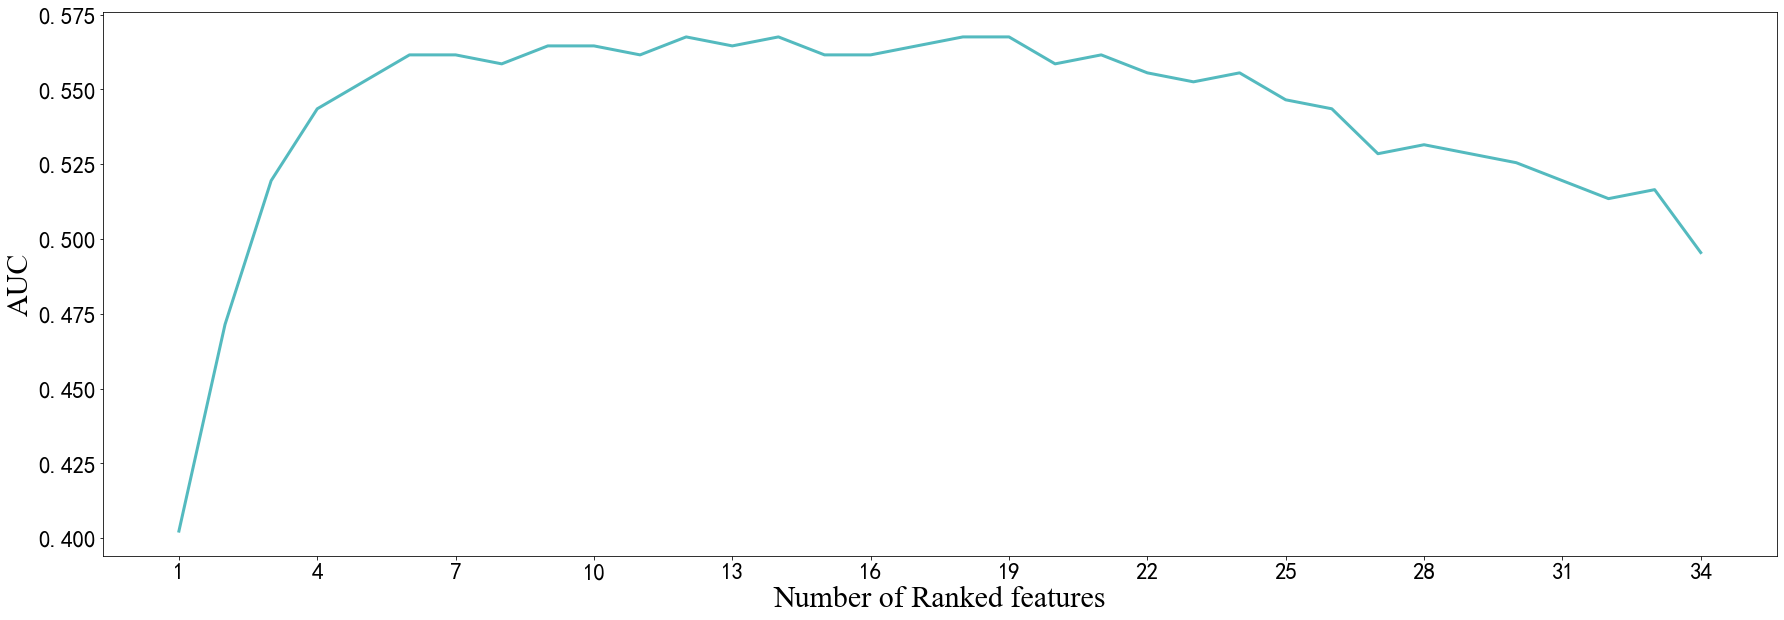

In [92]:
# 画图
# 如果模型画图不好，可以选择在excel中画图
import matplotlib.pyplot as plt
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

# r2折线图
# 分辨率参数-dpi，画布大小参数-figsize
plt.figure(figsize=(30,10))
plt.plot(list(range(1,len(f1_max_list)+1)),f1_max_list,
         color=(0.32941176470588235, 0.7294117647058823, 0.7490196078431373), label='AUC',linewidth=3) # 线粗细
# 设置坐标刻度值的大小
plt.tick_params(labelsize=23)

# 设置横纵坐标标题的名称以及对应字体格式
font_x = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 30,}
plt.xlabel('Number of Ranked features',font_x)
plt.ylabel('AUC',font_x)

# 设置横纵坐标刻度范围、间隔、名称
# x_list=list(df_feature['特征'])
plt.xticks(range(1,len(f1_max_list)+1,3))
# plt.yticks(list(range(len(f1_list))),f1_list,rotation=285)
# plt.legend(bbox_to_anchor=(1.1,1))  # 显示图例

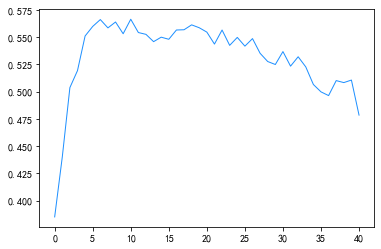

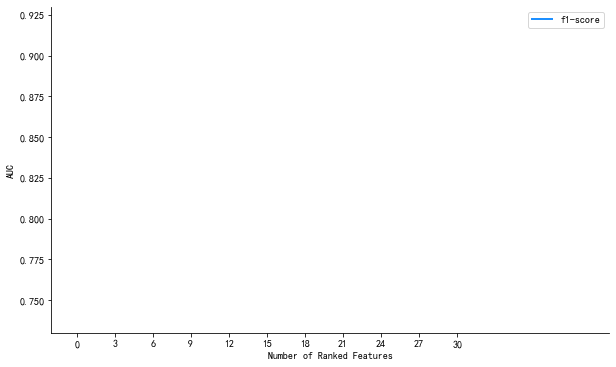

In [9]:
import matplotlib.pyplot as plt

plt.plot(f1_max_list,color='dodgerblue', linewidth=1 ,label='AUC')
# pd.DataFrame(f1_max_list).to_excel('AUC_four.xlsx')
f2 = pd.DataFrame(f1_max_list)
#作图
fig = plt.figure(figsize=(10, 6), facecolor='white')  #创建figure对象
ax = fig.add_subplot(1, 1, 1)  #获得Axes对象
ax.plot( f2[0], '-',color='dodgerblue', linewidth=2 ,label='f1-score')  
ax.set_xlabel('Number of Ranked Features')  #设置x轴标签
ax.set_ylabel('AUC')  #设置y轴标签
plt.ylim(0.73, 0.93)
plt.xticks(range(0,31,3))  
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend() 
plt.show()

## 保存逐步向前筛选的建模数据

In [93]:
f1_max_index=f1_max_list.index(max(f1_max_list))
print(f1_max_index)
feature_com_best=df_forward_result.loc[f1_max_index,'feature_names']
print(feature_com_best)

13
Index(['jaundice', 'biliary_disease', 'HBsAg', 'HBeAg', 'Gazzaniga_T', 'MSKCC',
       'Bismuth_C', 'gene_mutation', 'smoke', 'LC', 'PTCD_ERCP', 'DB',
       'tumor_CA19-9', 'BMI'],
      dtype='object')


In [94]:
str(feature_com_best).split('\'')

['Index([',
 'jaundice',
 ', ',
 'biliary_disease',
 ', ',
 'HBsAg',
 ', ',
 'HBeAg',
 ', ',
 'Gazzaniga_T',
 ', ',
 'MSKCC',
 ',\n       ',
 'Bismuth_C',
 ', ',
 'gene_mutation',
 ', ',
 'smoke',
 ', ',
 'LC',
 ', ',
 'PTCD_ERCP',
 ', ',
 'DB',
 ',\n       ',
 'tumor_CA19-9',
 ', ',
 'BMI',
 '],\n      dtype=',
 'object',
 ')']

In [95]:
feature_list=str(feature_com_best).split('\'')
feature_forward_select=feature_list[1:2*(f1_max_index+1):2]
feature_forward_select.insert(0,'label')

In [96]:
feature_forward_select

['label',
 'jaundice',
 'biliary_disease',
 'HBsAg',
 'HBeAg',
 'Gazzaniga_T',
 'MSKCC',
 'Bismuth_C',
 'gene_mutation',
 'smoke',
 'LC',
 'PTCD_ERCP',
 'DB',
 'tumor_CA19-9',
 'BMI']

In [97]:
# 业务角度要保留的重要变量
feature_forward_select.extend(['emaciation','drinking','tumor_AFP','tumor_CEA','tumor_CA125','tumor_size'])

In [98]:
df_model_forward=df_model[feature_forward_select]
df_model_forward.to_excel(project_path+'/data/result/feature_engineering/df_4.5_model_data_forward.xlsx')